In [85]:
# Import all nessasary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import optuna
from tqdm import tqdm
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold

In [3]:
# Upload metadata (2 files with attributes and phenotypes) and gene counts
metadat = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep="\t")
subj_metadat = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep="\t")
dat_gct = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct', sep="\t", skiprows=2)
# dat_gct can be already preprocessed file for faster calculations and uploadings (but here I used source data)

In [4]:
# Upload core matrisome genes and matrisome assosiated genes from file
matrisome_core = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/matrisome_all.tsv', sep='\t')
matrisome_core = matrisome_core.Gene.unique() #467
matrisome_associated = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/matrisome_associated_all.tsv', sep='\t')
matrisome_associated = matrisome_associated.Gene.unique() #1078
matrisome_genes = list(matrisome_core) + list(matrisome_associated) # combine core and associated genes together
len(matrisome_genes) #1545

1545

# Preparation of the data

In [6]:
# Filter by tissue type
relevant_tissues = ['Heart', 'Kidney', 'Liver', 'Lung', 'Muscle']
relevant_tissue_detailed = ['Whole Blood', 'Brain - Hippocampus', 'Brain - Cerebellum',
                            'Brain - Caudate (basal ganglia)', 'Brain - Putamen (basal ganglia)',
                            'Brain - Cortex']

metadat = metadat[
    (metadat['SMTS'].isin(relevant_tissues)) | 
    (metadat['SMTSD'].isin(relevant_tissue_detailed))]

# Further filter by sequencing type and batch conditions
metadat = metadat[metadat['SMAFRZE'] == 'RNASEQ']
metadat = metadat[metadat['SMNABTCHT'] != 'RNA isolation_PAXgene Tissue miRNA']

metadat.head(2)

,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
6,GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,...,13191500.0,11550200.0,0.003968,13340500.0,50.2809,0.006995,0.995041,NaN,0.0,49.9455
9,GTEX-1117F-0726-SM-5GIEN,1.0,B1,"2 pieces, no abnormalities",6.3,Heart,Heart - Atrial Appendage,0006631,1244.0,1097.0,...,13627100.0,9266070.0,0.003442,13756700.0,50.2367,0.030584,0.995711,NaN,0.0,49.9563


In [ ]:
# I want to make smaller dataset

# dat_gct.shape #(56200, 17384)
# relevant_columns = ['Description', 'Name'] + list(metadat['SAMPID'])
# dat_gct = dat_gct[dat_gct.columns.intersection(relevant_columns)]
# dat_gct.to_csv("gene_counts_tissues_of_interest.csv", index=False)
# dat_gct.head(3) #(56200, 3216)

In [7]:
# Extract donor information from SAMPID
metadat['donor'] = metadat['SAMPID'].apply(lambda x: "-".join(x.split("-")[:2]))

# Merge in metadat only needed
metadat = pd.merge(
    metadat[['SAMPID', 'SMTS', 'donor', 'SMTSD']],
    subj_metadat[['SUBJID', 'SEX', 'AGE']],
    left_on='donor',
    right_on='SUBJID'
)

metadat.drop('donor', axis=1, inplace = True)
metadat.head(2)

,SAMPID,SMTS,SMTSD,SUBJID,SEX,AGE
0,GTEX-1117F-0426-SM-5EGHI,Muscle,Muscle - Skeletal,GTEX-1117F,2,60-69
1,GTEX-1117F-0726-SM-5GIEN,Heart,Heart - Atrial Appendage,GTEX-1117F,2,60-69


In [8]:
# Sort and count occurrences of each tissue type in SMTSD
tissue_counts = metadat['SMTSD'].value_counts().sort_values(ascending=False)
tissue_counts = tissue_counts.reset_index()
tissue_counts

,SMTSD,count
0,Whole Blood,755
1,Muscle - Skeletal,641
2,Lung,431
3,Heart - Atrial Appendage,381
4,Heart - Left Ventricle,324
5,Brain - Cortex,225
6,Brain - Cerebellum,207
7,Liver,177
8,Kidney - Cortex,73


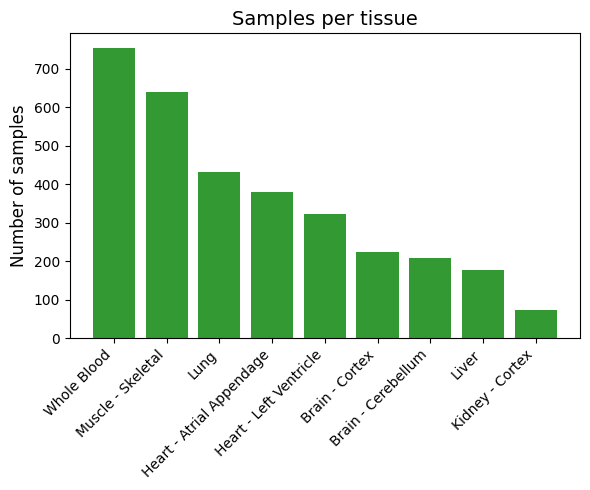

In [9]:
# Visualisation of the presence of each tissue type in SMTSD
plt.figure(figsize=(6, 5))

plt.bar(tissue_counts["SMTSD"], tissue_counts["count"], color="green", alpha=0.8)
plt.ylabel("Number of samples", fontsize=12)
plt.title("Samples per tissue", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()  

plt.show()

In [45]:
matrisome_counts

,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-2026-SM-5GZZC,GTEX-111FC-0326-SM-5GZZ1,GTEX-111FC-0626-SM-5N9CU,GTEX-111FC-0826-SM-5GZWO,GTEX-111FC-1126-SM-5GZWU,GTEX-111FC-3126-SM-5GZZ2,...,GTEX-ZZPT-0626-SM-5GZXT,GTEX-ZZPT-0926-SM-5GICZ,GTEX-ZZPT-1326-SM-5E43H,GTEX-ZZPT-2926-SM-5EQ5S,GTEX-ZZPT-3026-SM-5GZXH,GTEX-ZZPU-0426-SM-5GZYH,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-2626-SM-5E45Y
67,1013,2783,8179,7213,479,778,2835,2876,7831,13362,...,969,1647,13450,1120,7399,3413,8599,2048,4332,562
109,321,2272,3616,2753,246,600,2479,1247,1599,3483,...,501,1427,1739,475,4183,5061,3044,740,1959,225
120,3,71,28,74,4,7,113,37,92,14,...,2,55,97,14,13,5,143,77,178,3
176,728,7960,1004,4013,545,585,2939,996,4902,803,...,1771,2811,10482,224,712,453,5089,706,4147,822
333,223,106,108,190,112,145,75,110,72,288,...,209,135,352,746,147,13291,278,150,156,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55261,8,0,0,1,4,2,2,0,4,2,...,0,0,7,0,14,42241,2,8,2,0
55485,1453,77468,1985,23873,573,1953,37835,13903,63793,2541,...,1519,25251,33054,1479,10692,6338,40754,8179,87486,1205
55500,50,736,7249,164,43,44,1581,508,1138,10074,...,46,351,188,4141,3482,69,940,500,1553,54
55512,1532,2014,4408,7064,8610,2901,2820,2651,3738,5570,...,6130,3711,5837,7381,6123,3063,6513,3658,5112,6064


In [47]:
# Keep gene counts only for matrisome genes
matrisome_counts = dat_gct[dat_gct['Description'].isin(matrisome_genes)] # 907 out of 1545 matrisome genes were found in data

# Retain only necessary samples and genes with total counts > 200 in all samples
values_to_keep = metadat['SAMPID'].values
values_to_keep = np.append(values_to_keep, 'Description')
matrisome_counts = matrisome_counts[matrisome_counts.columns.intersection(values_to_keep)]
matrisome_counts = matrisome_counts[matrisome_counts.iloc[:, 2:].sum(axis=1) > 200]
matrisome_counts.shape # (902, 3215)

(902, 3215)

In [48]:
# Make nessasary orientation and indexing for dataframe
matrisome_counts = matrisome_counts.set_index('Description').T
matrisome_counts = matrisome_counts.reset_index()

In [49]:
# Merge metadata tables, retain only necessary columns
merged_df = pd.merge(
    matrisome_counts,
    metadat[['SAMPID', 'SMTS', 'SEX', 'AGE']],
    left_on='index',
    right_on='SAMPID',
    how='left'
)

#merged_df = merged_df.dropna(subset=['SAMPID'])
merged_df = merged_df.drop(columns=['SAMPID', 'index'])
merged_df.head(2)

,AGRN,VWA1,MMP23B,MEGF6,MASP2,ANGPTL7,PLOD1,CELA2A,CELA2B,MST1L,...,GPC3,FGF13,F9,BGN,PLXNB3,HCFC1,PLXNA3,SMTS,SEX,AGE
0,1013,321,3,728,223,32,1251,102,14,29,...,48,565,8,1453,50,1532,220,Muscle,2,60-69
1,2783,2272,71,7960,106,210,6519,12,7,157,...,1942,87,0,77468,736,2014,2214,Heart,2,60-69


In [50]:
# One-hot encode character columns
char_col = ['AGE', 'SMTS', 'SEX']
encoder = OneHotEncoder(sparse_output=False, drop = 'first')
one_hot_encoded = encoder.fit_transform(merged_df[char_col])

#Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(char_col), index=merged_df.index)
one_hot_df.head(3)

,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,SMTS_Brain,SMTS_Heart,SMTS_Kidney,SMTS_Liver,SMTS_Lung,SMTS_Muscle,SEX_2
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([merged_df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(char_col, axis=1)
df_encoded.head(2)

,AGRN,VWA1,MMP23B,MEGF6,MASP2,ANGPTL7,PLOD1,CELA2A,CELA2B,MST1L,...,AGE_50-59,AGE_60-69,AGE_70-79,SMTS_Brain,SMTS_Heart,SMTS_Kidney,SMTS_Liver,SMTS_Lung,SMTS_Muscle,SEX_2
0,1013,321,3,728,223,32,1251,102,14,29,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2783,2272,71,7960,106,210,6519,12,7,157,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


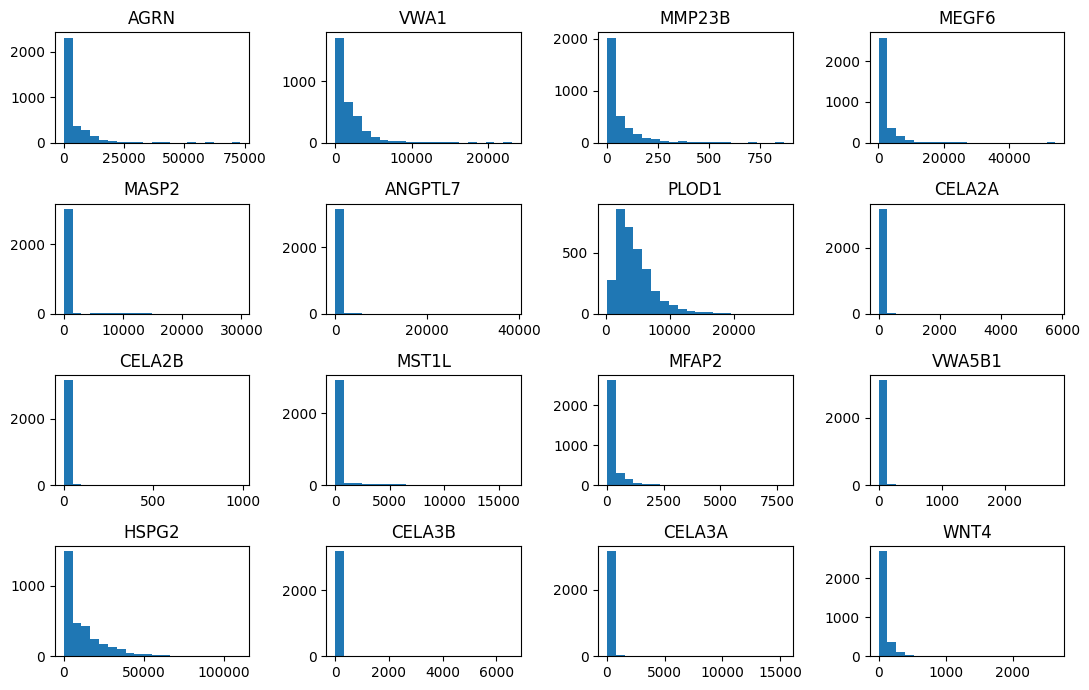

In [52]:
# Plot counts distribution for the first 16 genes
genes_subset = df_encoded.columns[:16]
fig, axes = plt.subplots(4, 4, figsize=(11, 7))

for i, gene in enumerate(genes_subset):
    axes[i // 4, i % 4].hist(df_encoded[gene], bins=20)
    axes[i // 4, i % 4].set_title(gene)

plt.tight_layout()
plt.show()

In [57]:
# Check duplicates
print(df_encoded.columns[df_encoded.columns.duplicated()])
df_encoded = df_encoded.drop('ELFN2', axis=1)
print(df_encoded.columns[df_encoded.columns.duplicated()])

Index(['ELFN2'], dtype='object')
Index([], dtype='object')


In [ ]:
# Save encoded data
# df_encoded.to_csv("data_encoded.csv", index=False)

<Axes: >

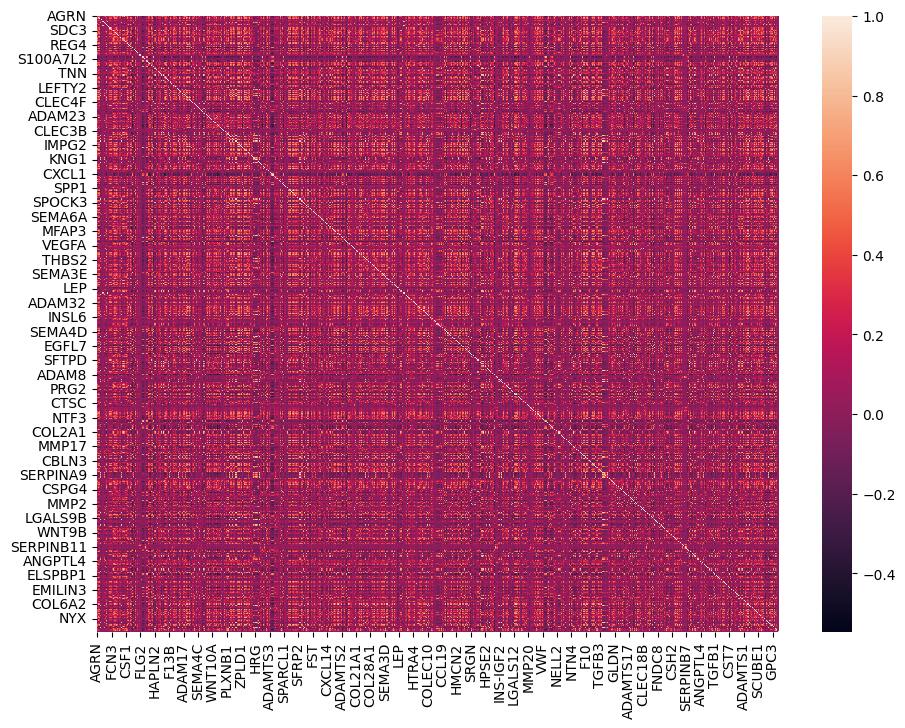

In [58]:
# Visualise correlation matrix
corr_data = df_encoded[df_encoded.columns[:902]].corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr_data)
# plt.savefig('corr_all_genes.png')

In [59]:
# Check the number of highly correlated pairs
correlation_pairs = corr_data.unstack()
high_corr_pairs = correlation_pairs[(correlation_pairs > 0.7) & (correlation_pairs < 1)]
len(high_corr_pairs) / 2

5732.0

In [60]:
# Check mean and median levels of expression for all genes
mean_expression = df_encoded[df_encoded.columns[:902]].mean(axis=0)
median_expression = df_encoded[df_encoded.columns[:902]].median(axis=0)

summary_stats = pd.DataFrame({
    'Mean': mean_expression,
    'Median': median_expression
})
summary_stats.head(3)

,Mean,Median
AGRN,3438.590230,1500.5
VWA1,1668.249844,988.0
MMP23B,55.500622,22.0


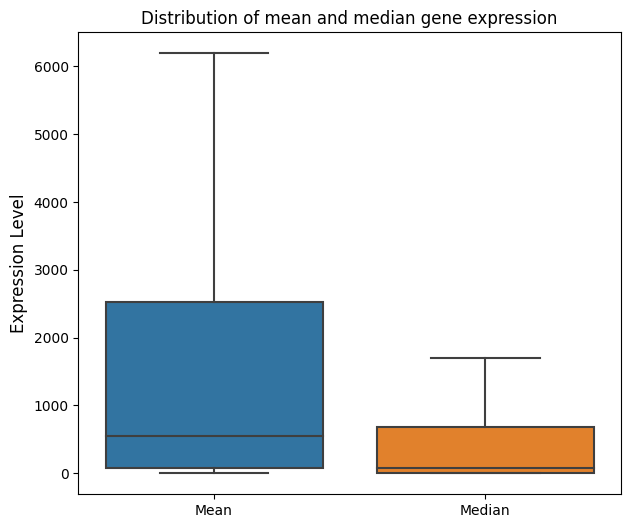

In [61]:
# Plot levels of expression
melted_summary = summary_stats.melt(var_name='Statistic', value_name='Expression Level')

plt.figure(figsize=(7, 6))
sns.boxplot(x='Statistic', y='Expression Level', data=melted_summary, showfliers=False)  # showfliers=False to hide outliers
plt.title('Distribution of mean and median gene expression')
plt.ylabel('Expression Level', fontsize=12)
plt.xlabel('')
# plt.show()
plt.savefig('distribution_gene_expr.png')

# Regression between gene expression and age

In [76]:
# !pip install rnanorm
from rnanorm import CPM
from sklearn import set_config
set_config(transform_output="pandas")

In [77]:
# This is clean version of previosly uploaded dat_gct (just for speed increasing)
dat_gct2 = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/gene_counts_tissues_of_interest.csv', sep=",")

In [78]:
# manipulations with data to perform CPM normalisation
dat_gct2.drop('Name', axis=1, inplace = True)
dat_gct2 = dat_gct2[dat_gct2.iloc[:, 1:].sum(axis=1) > 200]
dat_gct2 = dat_gct2.set_index('Description').T
# dat_gct2 = matrisome_counts.reset_index()
dat_gct2 = CPM().fit_transform(dat_gct2)

In [81]:
# Retain only necessary genes
cpm_gct2 = dat_gct2.T.reset_index()
cpm_gct2 = cpm_gct2[cpm_gct2['index'].isin(matrisome_genes)] 
cpm_gct2 = cpm_gct2.set_index('index').T
cpm_gct2 = cpm_gct2.reset_index()
cpm_gct2.head(2)

index,index,AGRN,VWA1,MMP23B,MEGF6,MASP2,ANGPTL7,PLOD1,CELA2A,CELA2B,...,COL4A5,CHRDL1,GPC4,GPC3,FGF13,F9,BGN,PLXNB3,HCFC1,PLXNA3
0,GTEX-1117F-0426-SM-5EGHI,21.379832,6.774853,0.063316,15.364776,4.706518,0.675375,26.402932,2.152757,0.295476,...,14.41503,5.001994,8.273341,1.013062,11.924586,0.168844,30.666235,1.055273,32.333567,4.643202
1,GTEX-1117F-0726-SM-5GIEN,58.985910,48.155224,1.504851,168.712843,2.246679,4.450967,138.170732,0.254341,0.148366,...,9.26225,43.979793,27.786751,41.160847,1.843972,0.000000,1641.940521,15.599579,42.686893,46.925909


In [82]:
# Merge count table with age
merged_df = pd.merge(
    cpm_gct2,
    metadat[['SAMPID', 'AGE']],
    left_on='index',
    right_on='SAMPID',
    how='left'
)

merged_df = merged_df.drop(columns=['SAMPID', 'index'])
merged_df.head(2)

,AGRN,VWA1,MMP23B,MEGF6,MASP2,ANGPTL7,PLOD1,CELA2A,CELA2B,MST1L,...,CHRDL1,GPC4,GPC3,FGF13,F9,BGN,PLXNB3,HCFC1,PLXNA3,AGE
0,21.379832,6.774853,0.063316,15.364776,4.706518,0.675375,26.402932,2.152757,0.295476,0.612058,...,5.001994,8.273341,1.013062,11.924586,0.168844,30.666235,1.055273,32.333567,4.643202,60-69
1,58.985910,48.155224,1.504851,168.712843,2.246679,4.450967,138.170732,0.254341,0.148366,3.327628,...,43.979793,27.786751,41.160847,1.843972,0.000000,1641.940521,15.599579,42.686893,46.925909,60-69


In [83]:
# Perform regression between age and number of counts for each gene
df_volcano = merged_df.copy()

age_mapping = {'20-29': 24.5, '30-39': 34.5, '40-49': 44.5, '50-59': 54.5, '60-69': 64.5, '70-79': 74.5}
df_volcano['AGE'] = df_volcano['AGE'].map(age_mapping)
df_volcano.drop(['ELFN2'], axis=1, inplace = True)

genes_all = df_volcano.columns[:900]

results = {}
for gene in genes_all:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_volcano['AGE'], df_volcano[gene])
    results[gene] = {'slope': slope, 'p_value': p_value}

results_df = pd.DataFrame.from_dict(results, orient='index')

               slope       p_value
S100A9   -129.518641  4.642706e-30
S100A8    -25.518405  1.225889e-20
SERPINA1  -23.582634  3.782271e-03
SFTPB     -20.315415  5.400991e-05
S100A11   -14.769158  1.371662e-29
SFTPC     -13.481803  2.976689e-04
SFTPA2    -12.718803  2.200103e-05
SRGN      -12.365322  1.627547e-21
SFTPA1    -10.623037  7.718168e-06
S100A12    -9.910607  2.434568e-21


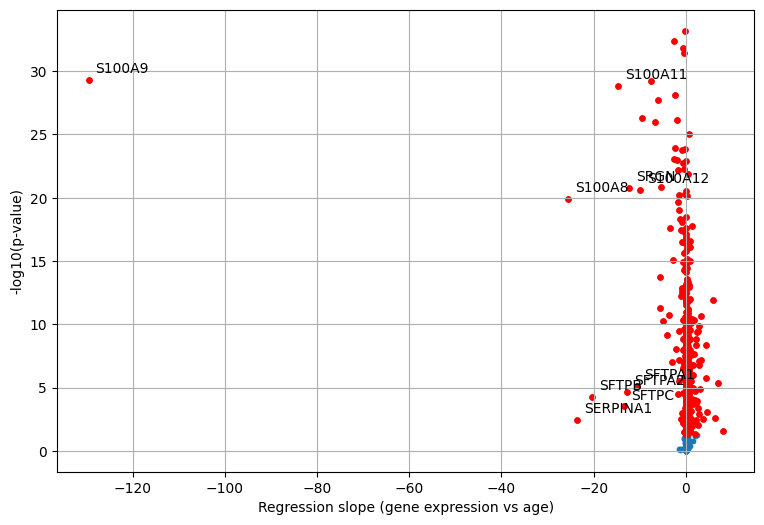

In [84]:
# Make volcano plot (red color - significant genes, blue - insignificant)
plt.figure(figsize=(9, 6))
plt.scatter(results_df['slope'], -np.log10(results_df['p_value']), s=10)

significant_genes = results_df[results_df['p_value'] < 0.05]
plt.scatter(significant_genes['slope'], -np.log10(significant_genes['p_value']), s=15, color='red')

# Find significant genes with highest slope
top_10_genes = results_df.reindex(results_df['slope'].abs().sort_values(ascending=False).index)[:10]
print(top_10_genes)
for gene, row in top_10_genes.iterrows():
    plt.annotate(gene, (row['slope'], -np.log10(row['p_value'])), textcoords="offset points", xytext=(5,5), ha='left') # Adjust offset as needed

plt.xlabel("Regression slope (gene expression vs age)")
plt.ylabel("-log10(p-value)")
plt.grid(True)
plt.show()

In [86]:
# Make merged dataframe again to test other normalisation techniques
merged_df = pd.merge(
    matrisome_counts,
    metadat[['SAMPID', 'AGE']],
    left_on='index',
    right_on='SAMPID',
    how='left'
)

merged_df = merged_df.drop(columns=['SAMPID', 'index'])
merged_df.head(2)

,AGRN,VWA1,MMP23B,MEGF6,MASP2,ANGPTL7,PLOD1,CELA2A,CELA2B,MST1L,...,CHRDL1,GPC4,GPC3,FGF13,F9,BGN,PLXNB3,HCFC1,PLXNA3,AGE
0,1013,321,3,728,223,32,1251,102,14,29,...,237,392,48,565,8,1453,50,1532,220,60-69
1,2783,2272,71,7960,106,210,6519,12,7,157,...,2075,1311,1942,87,0,77468,736,2014,2214,60-69


In [91]:
# Try Z-scaling of data
df_volcano = merged_df.copy()

age_mapping = {'20-29': 24.5, '30-39': 34.5, '40-49': 44.5, '50-59': 54.5, '60-69': 64.5, '70-79': 74.5}
df_volcano['AGE'] = df_volcano['AGE'].map(age_mapping)
df_volcano.drop(['ELFN2'], axis=1, inplace = True)

genes_all = df_volcano.columns[:900]

scaler = StandardScaler()
df_volcano[genes_all] = scaler.fit_transform(df_volcano[genes_all])

results = {}
for gene in genes_all:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_volcano['AGE'], df_volcano[gene])
    results[gene] = {'slope': slope, 'p_value': p_value}

results_df = pd.DataFrame.from_dict(results, orient='index')

             slope       p_value
CSTA     -0.017413  3.373809e-32
CLEC4E   -0.017168  2.519499e-31
CLEC4A   -0.016882  2.509878e-30
S100A11  -0.016783  5.509476e-30
HPSE     -0.016570  2.948330e-29
S100A4   -0.016409  1.034974e-28
SERPINB1 -0.016163  6.864710e-28
ANXA11   -0.015912  4.571102e-27
ANXA3    -0.015873  6.093403e-27
S100A9   -0.015719  1.914922e-26


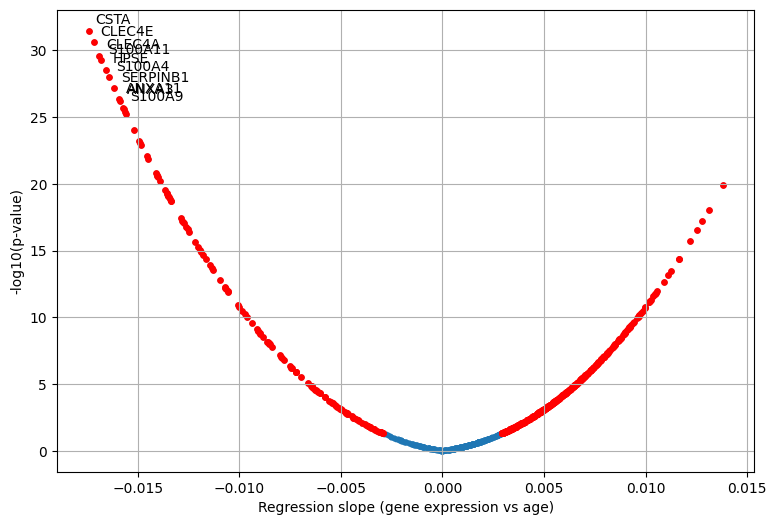

In [92]:
plt.figure(figsize=(9, 6))
plt.scatter(results_df['slope'], -np.log10(results_df['p_value']), s=10)

significant_genes = results_df[results_df['p_value'] < 0.05]
plt.scatter(significant_genes['slope'], -np.log10(significant_genes['p_value']), s=15, color='red')

top_10_genes = results_df.reindex(results_df['slope'].abs().sort_values(ascending=False).index)[:10]
print(top_10_genes)
for gene, row in top_10_genes.iterrows():
    plt.annotate(gene, (row['slope'], -np.log10(row['p_value'])), textcoords="offset points", xytext=(5,5), ha='left')

plt.xlabel("Regression slope (gene expression vs age)")
plt.ylabel("-log10(p-value)")
plt.grid(True)
plt.show()

In [93]:
# Try MinMax scaling
df_volcano = merged_df.copy()

age_mapping = {'20-29': 24.5, '30-39': 34.5, '40-49': 44.5, '50-59': 54.5, '60-69': 64.5, '70-79': 74.5}
df_volcano['AGE'] = df_volcano['AGE'].map(age_mapping)
df_volcano.drop(['ELFN2'], axis=1, inplace = True)

genes_all = df_volcano.columns[:900]

scaler = MinMaxScaler()
df_volcano[genes_all] = scaler.fit_transform(df_volcano[genes_all])

results = {}
for gene in genes_all:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_volcano['AGE'], df_volcano[gene])
    results[gene] = {'slope': slope, 'p_value': p_value}

results_df = pd.DataFrame.from_dict(results, orient='index')

             slope       p_value
LGI4      0.001977  9.231170e-19
SERPINB8 -0.001809  8.541154e-20
SEMA4C    0.001677  5.876236e-18
CTSS     -0.001627  8.299720e-23
ADAM8    -0.001606  7.708845e-20
IL16     -0.001592  1.141777e-14
S100Z    -0.001592  3.068526e-20
CSTA     -0.001541  3.373809e-32
PTN       0.001440  3.149956e-14
S100P    -0.001432  4.695749e-20


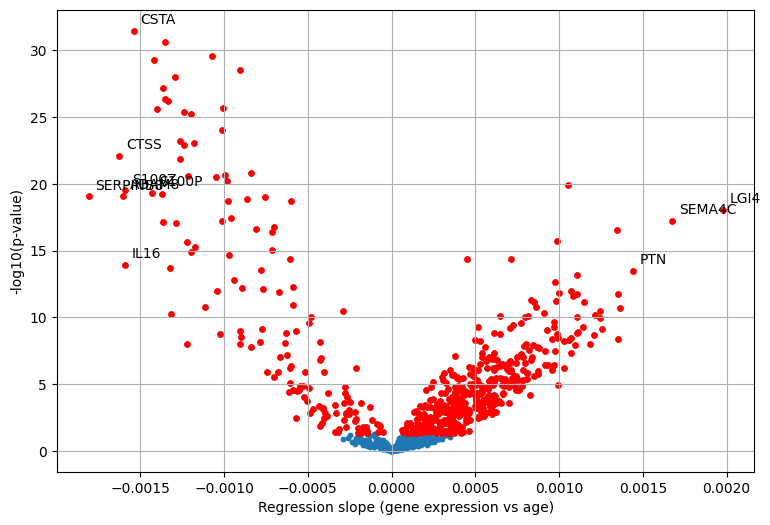

In [95]:
plt.figure(figsize=(9, 6))
plt.scatter(results_df['slope'], -np.log10(results_df['p_value']), s=10)

significant_genes = results_df[results_df['p_value'] < 0.05]
plt.scatter(significant_genes['slope'], -np.log10(significant_genes['p_value']), s=15, color='red')

top_10_genes = results_df.reindex(results_df['slope'].abs().sort_values(ascending=False).index)[:10]
print(top_10_genes)
for gene, row in top_10_genes.iterrows():
    plt.annotate(gene, (row['slope'], -np.log10(row['p_value'])), textcoords="offset points", xytext=(5,5), ha='left')

plt.xlabel("Regression slope (gene expression vs age)")
plt.ylabel("-log10(p-value)")
plt.grid(True)
plt.show()

# Prediction of gene expression based on expression of other genes (and metadata: age, gender, tissue)

In [ ]:
# This is function for model optimisation, I did it with optuna with 3 fold crossvalidation inside

def find_best_params(reg, param_grid, X_train, X_test, y_train, y_test, n_cv=3, n_trials=15):

    mean_expression = round((y_train.mean() + y_test.mean())/2, 2)
    
    params = {}
    def my_trial(trial, _X, _y):
        _X = _X.to_numpy()
        _y = _y.to_numpy()
        # Suggest all parameters
        trial_grid = {}
        for key in param_grid:
            trial_grid[key] = trial.suggest_int(key,  param_grid[key][0], param_grid[key][1])
        # Run CV on trial grid
        cv_scores = []
        kf = KFold(n_splits=n_cv, shuffle=True, random_state=42) # Inner CV
        for train_index, val_index in kf.split(_X):
            X_train_cv, X_val_cv = _X[train_index], _X[val_index]
            y_train_cv, y_val_cv = _y[train_index], _y[val_index]
            model = reg(**trial_grid)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            cv_scores.append(mean_squared_error(y_val_cv, y_pred_cv))
        return np.mean(cv_scores)
    study = optuna.create_study(direction='minimize', 
                                pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5),
                                sampler=TPESampler(seed=42))
    
    study.optimize(lambda trial: my_trial(trial, X_train, y_train), n_trials=n_trials, show_progress_bar=False, n_jobs=-1)
    best_params = study.best_params
    best_model = reg(**best_params)
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = round(mean_squared_error(y_train, y_train_pred) ** 0.5, 2)
    test_rmse = round(mean_squared_error(y_test, y_test_pred) ** 0.5, 2)
    train_r2 = round(r2_score(y_train, y_train_pred), 2)
    test_r2 = round(r2_score(y_test, y_test_pred), 2)

    return [mean_expression, train_rmse, test_rmse, train_r2, test_r2], best_params

In [ ]:
# These are all models I tested and corresponding parameters

models = [ElasticNet, KNeighborsRegressor, DecisionTreeRegressor, Ridge, Lasso,
          RandomForestRegressor,XGBRegressor, SVR]

params_all = [{'alpha' : [1, 100]},
          {'n_neighbors' : [3, 20]},
          {'max_depth': [5, 20], 'min_samples_split': [2, 10]},
          {'alpha': [1, 1000]},
          {'alpha' : [1, 100]},
          {"n_estimators": [50, 150], "max_depth": [3, 15]},
          {'n_estimators': [50, 150], 'max_depth': [3, 10]},
          {'C' : [1, 100]}, ]

In [ ]:
# Supress warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Separate train and test, find correlations before cycle to make everything faster
df = pd.read_csv('./data_encoded.csv')
genes_all = list(df.columns[:902])
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
X_train = pd.DataFrame(X_train, columns=df.columns) 
X_test = pd.DataFrame(X_test, columns=df.columns) 

corr_genes = X_train.corr()

# Go through each model, find optimal parameters and save results of training and performance in two files: 
# one with parameters for each model, second with training/testing results on metrics
for ind, (reg, param_grid) in tqdm(enumerate(zip(models, params_all))):
    results = {}
    params_df = {key:[] for key in param_grid.keys()}
    params_df['gene'] = []

    def remove_corr_genes(df_encoded):
        correlation_pairs = corr_genes.unstack()
        high_corr_pairs = correlation_pairs[(correlation_pairs > 0.7) & (correlation_pairs < 1)]
        
        # Remove highly correlated genes (the most redundant gene from pair)
        genes_to_drop = set()
        for (gene1, gene2), correlation in high_corr_pairs.items():
            if gene1 not in genes_to_drop and gene2 not in genes_to_drop:
                if np.mean(np.abs(corr_genes[gene1])) > np.mean(np.abs(corr_genes[gene2])):
                    genes_to_drop.add(gene1)
                else:
                    genes_to_drop.add(gene2)

        genes_to_keep = list(set(df_encoded.columns) - genes_to_drop)
        return genes_to_keep

    # Make model for each gene separately
    for gene in genes_all:
        y_train_gene = X_train[gene].copy()
        X_train_gene = X_train.drop(columns=gene).copy()

        y_test_gene = X_test[gene].copy()
        X_test_gene = X_test.drop(columns=gene).copy()

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_gene)
        X_test_scaled = scaler.transform(X_test_gene)

        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_gene.columns) 
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_gene.columns) 

        genes_to_keep = remove_corr_genes(X_train_scaled)
        X_train_scaled = X_train_scaled[genes_to_keep]
        X_test_scaled = X_test_scaled[genes_to_keep]

        metrics, params = find_best_params(reg, param_grid, X_train_scaled, X_test_scaled, y_train_gene, y_test_gene, 3, 15)
        results[gene] = metrics
        for key in params:
            params_df[key] += [params[key]]
        params_df['gene'] += [gene]


    results_lin = pd.DataFrame.from_dict(results, orient='index', columns=['Mean_Expression', 'Train_RMSE', 'Test_RMSE', 'Train_R2', 'Test_R2'])
    params = pd.DataFrame.from_dict(params_df)

    results_lin.to_csv(f'./metrics_{ind}.csv')
    params.to_csv(f'./params_{ind}.csv', index=False)

 # Visualisation of the results after predictions

In [41]:
# Here you can choose data you want, uncomment it and do visualisation

# res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/metrics_Lasso.csv')
res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/metrics_ElasticNet.csv')
# res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/metrics_KNeighborsRegressor.csv')
# res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/metrics_DecisionTreeRegressor.csv')
# res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/rid_results_all_alpha100.csv')
# res = pd.read_csv('/kaggle/input/tissue-specific-gene-expression-for-age-groups/metrics_Ridge.csv')

res.head(3)

,Unnamed: 0,Mean_Expression,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,AGRN,3472.09,1384.84,1345.98,0.92,0.93
1,VWA1,1686.80,1092.26,1219.57,0.75,0.69
2,MMP23B,55.73,49.72,51.90,0.60,0.59


In [42]:
# Check results with negative R2
res[res['Test_R2'] < 0]

,Unnamed: 0,Mean_Expression,Train_RMSE,Test_RMSE,Train_R2,Test_R2
57,FLG2,46.14,117.14,100.38,0.62,-0.80
58,CRNN,52.00,724.95,236.34,0.26,-3.52
63,S100A7L2,0.07,0.27,0.33,0.00,-0.01
138,IL1F10,0.21,1.05,0.61,0.00,-0.01
169,TDGF1,29.13,110.31,139.37,0.53,-0.35
226,MUC7,112.25,1742.80,285.74,0.04,-0.07
360,GRIFIN,0.64,1.37,1.18,0.00,-0.01
448,IFNA5,1.18,2.46,2.03,0.00,-0.01
559,FGF19,3.00,54.34,11.76,0.01,-0.02
577,MMP13,3.86,29.53,50.68,0.75,-2.90


In [38]:
# Check main statistics
print('mean:', round(res['Test_R2'].mean(), 2))
print('median:', round(res['Test_R2'].median(), 2))
print('min:', round(res['Test_R2'].min(), 2))
print('neg r2:', res[res['Test_R2'] < 0].shape[0])

mean: -0.46
median: 0.6
min: -390.82
neg r2: 101


Number of genes with R2 < -1: 5


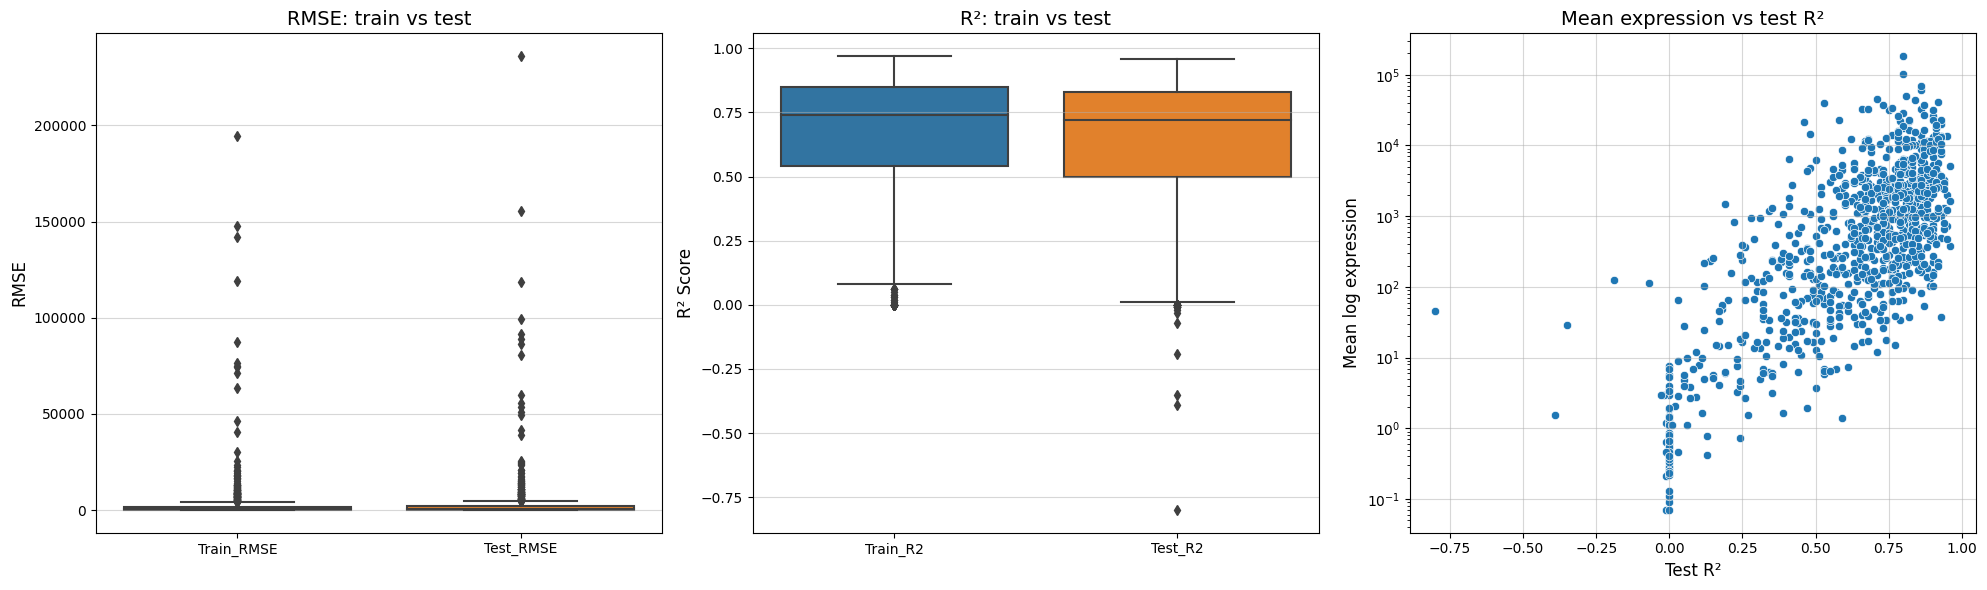

In [43]:
# Plot everything
print('Number of genes with R2 < -1:', res[res['Test_R2'] <= -1].shape[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# plot for RMSE
sns.boxplot(data=res[['Train_RMSE', 'Test_RMSE']], ax=axes[0])
axes[0].set_title('RMSE: train vs test', fontsize=14)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].grid(axis='y', alpha=0.5)

# plot for R²
sns.boxplot(data=res[res['Test_R2'] > -1][['Train_R2', 'Test_R2']], ax=axes[1])
axes[1].set_title('R²: train vs test', fontsize=14)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].grid(axis='y', alpha=0.5)

# mean expression vs test R²
sns.scatterplot(x=res[res['Test_R2'] > -1]['Test_R2'], y=res['Mean_Expression'], ax=axes[2])
axes[2].set_title('Mean expression vs test R²', fontsize=14)
axes[2].set_xlabel('Test R²', fontsize=12)
axes[2].set_ylabel('Mean log expression', fontsize=12)
axes[2].set_yscale('log')
axes[2].grid(alpha=0.5)

plt.tight_layout()
plt.show()
# plt.savefig('decision_tree_no_corr_optuna.png')

In [39]:
# Check correlation between expression (number of counts) and R2
pearson_corr, pearson_pval = pearsonr(res['Mean_Expression'], res['Test_R2'])
print(f"Pearson Correlation: {pearson_corr:.2f}, p-value: {pearson_pval:.2e}")
spearman_corr, spearman_pval = spearmanr(res['Mean_Expression'], res['Test_R2'])
print(f"Spearman Correlation: {spearman_corr:.2f}, p-value: {spearman_pval:.2e}")

Pearson Correlation: 0.03, p-value: 4.37e-01
Spearman Correlation: 0.56, p-value: 6.50e-76
